In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab.drive import mount
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from textblob import TextBlob

nltk.download("stopwords")
nltk.download("punkt")
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
mount("MyDrive")

Drive already mounted at MyDrive; to attempt to forcibly remount, call drive.mount("MyDrive", force_remount=True).


In [3]:
df = pd.read_csv(
    "/content/MyDrive/MyDrive/Reddit_Combi.csv",
    sep=";",
    usecols=["Body_Title", "label"],
)

In [4]:
df.head()

,Body_Title,label
0,Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Body_Title  3123 non-null   object
 1   label       3123 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.9+ KB


### EDA (Exploratory Data Analysis)

-   Menvisualisasikan distribusi label
-   Menvisualisasikan sebaran panjang teks artikel berdasarkan label
-   Membuang outlier berdasarkan panjang teks dengan metode IQR


In [6]:
df["label"].value_counts()

label
1    2745
0     378
Name: count, dtype: int64

<ipython-input-7-d822443294ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="label", palette="Set2")


[Text(0, 0, '378')]

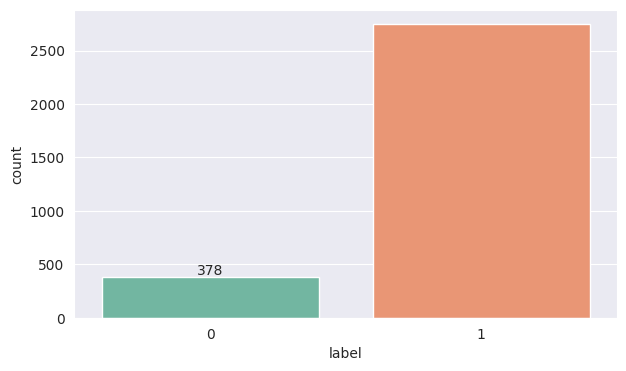

In [7]:
plt.figure(figsize=(7, 4))
ax = sns.countplot(data=df, x="label", palette="Set2")
ax.bar_label(ax.containers[0])

<Axes: xlabel='Body_Title', ylabel='Density'>

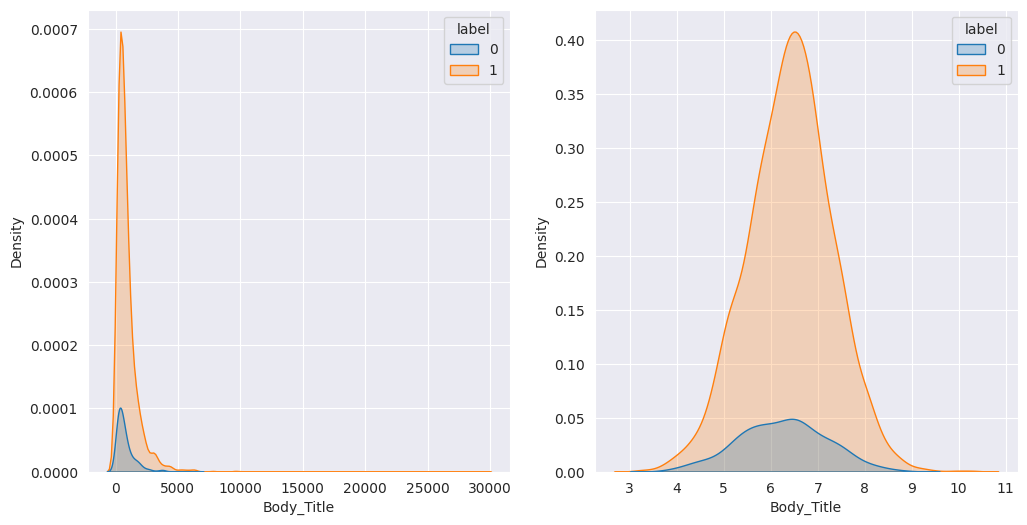

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(x=df["Body_Title"].str.len(), fill=True, hue=df["label"])

plt.subplot(1, 2, 2)
sns.kdeplot(x=df["Body_Title"].str.len().apply(np.log1p), fill=True, hue=df["label"])

In [9]:
text_lengths = df["Body_Title"].str.len()

Q1 = text_lengths.quantile(0.25)
Q3 = text_lengths.quantile(0.75)
IQR = Q3 - Q1

df = df[~((text_lengths < (Q1 - 1.5 * IQR)) | (text_lengths > (Q3 + 1.5 * IQR)))]

<Axes: xlabel='Body_Title', ylabel='Density'>

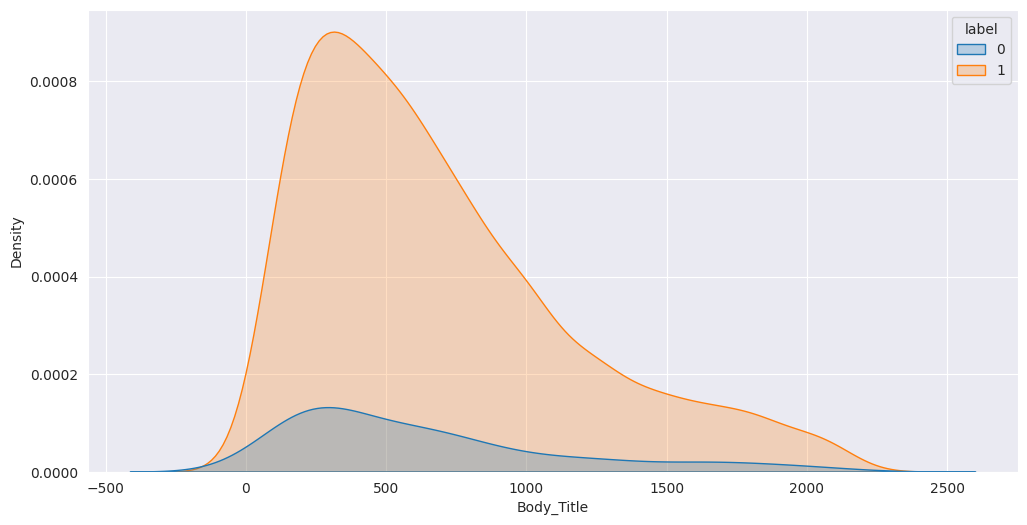

In [10]:
plt.figure(figsize=(12, 6))
sns.kdeplot(x=df["Body_Title"].str.len(), fill=True, hue=df["label"])

### Data preprocessing

Karena terdapat ketidakseimbangan label pada data, maka akan digunakan teknik _over sampling_ dengan menduplikasi data yang tidak seimbang sampai jumlahnya sama besar. Selanjutnya, setelah melalui proses trial & error, data akan diambil sebanyak 2000 sampel saja, karena lebih dari itu memakan waktu yang sangat lama ketika melakukan preprocessing. Data yang disampel sudah seimbang.

Data akan displit menjadi train dan test dengan test size sebesar 10%.

Untuk memastikan bahwa teks dapat memberikan informasi yang berharga maka dilakukan tahapan preprocessing, sebagai berikut:

1.  Mengubah semua teks menjadi huruf kecil (menjaga konsistensi teks).
2.  Membuang noise seperti; special character, angka, tautan, dll (membuang informasi yang tidak berharga untuk model).
3.  Memperbaiki kesalahan ejaan (menjaga konsistensi penulisan kata).
4.  Tokenisasi teks (memecah teks menjadi token atau kata secara individu).
5.  Membuang stop words (membuang kata-kata yang sering muncul dan tidak terlalu bermakna).
6.  Membatasi jumlah kata sebanyak 512 kata (menghindari teks yang terlalu panjang)
7.  Melakukan stemming (mengembalikan kata menjadi kata dasar dengan membuang imbuhan).
8.  Vektorisasi teks menggunakan TF-IDF (mengubah teks menjadi angka agar dapat dimengerti model).


In [11]:
num_stres = (df["label"] == 1).sum()

stres = df[df["label"] == 1].sample(1000, random_state=2024)
normal = (
    df[df["label"] == 0].sample(num_stres, replace=True).sample(1000, random_state=2024)
)

over_sampled = pd.concat([stres, normal], axis=0).reset_index(drop=True)

In [12]:
over_sampled["label"].value_counts()

label
1    1000
0    1000
Name: count, dtype: int64

In [13]:
X = over_sampled["Body_Title"]
y = over_sampled["label"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2024, stratify=y
)

In [15]:
class TextPreprocess(TransformerMixin):
    def __init__(self, max_sequence_length: int = 512) -> None:
        super().__init__()
        self.stop_words = set(stopwords.words("english"))
        self.stemmer = PorterStemmer()
        self.max_sequence_length = max_sequence_length

    def remove_noise(self, text: str) -> str:
        # Membuang noise
        patterns = [
            r"[^\w\s]",  # Membuang tanda baca
            r"\d",  # Membuang angka
            r"<.*?>",  # Membuang tag html
            r"http\S+",  # Membuang tautan
            r"\S+@\S+",  # Membuang email
            r"\s+",  # Membuang spasi yang berlebihan
        ]

        for pattern in patterns:
            text = re.sub(pattern, " ", text)

        return text.strip()

    def spell_correction_tokenize(self, text: str) -> list[str]:
        # Memperbaiki ejaan dan tokenisasi teks
        return list(TextBlob(text).correct().tokenize())

    def remove_stopwords(self, text: list[str]) -> list[str]:
        # Membuang stop words
        return [word for word in text if word not in self.stop_words]

    def stemming(self, text: list[str]) -> list[str]:
        # Stemming
        return " ".join([self.stemmer.stem(word) for word in text])

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.Series, y=None):
        return (
            X.str.lower()
            .apply(self.remove_noise)
            .apply(self.spell_correction_tokenize)
            .apply(self.remove_stopwords)
            .apply(self.stemming)
        )

In [16]:
text_pipeline = Pipeline(
    [
        ("text_preprocess", TextPreprocess()),
        ("vectorize", TfidfVectorizer()),
    ]
)

In [17]:
X_train = text_pipeline.fit_transform(X_train)
X_test = text_pipeline.transform(X_test)

### Modeling

RandomForestClassifier akan digunakan sebagai baseline model dan dilakukan hyperparameter tuning, dengan hyperparameter yang dituning sebagai berikut:

-   n_estimators: [50, 100, 200]
-   max_depth: [16, 32]
-   max_features: [sqrt, log2]
-   min_samples_split: [2, 5]

Untuk memastikan performa model yang robust, maka dilakukan juga cross validation dengan jumlah split sebanyak 3. Metrik utama yang digunakan dalam tuning adalah akurasi, model dengan akurasi tertinggi akan dianggap sebagai model terbaik.


In [18]:
rf = RandomForestClassifier(n_jobs=-1, random_state=2024)

In [19]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [16, 32],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)

In [20]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2024),
             n_jobs=-1,
             param_grid={'max_depth': [16, 32],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [22]:
grid.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [23]:
results = pd.DataFrame(grid.cv_results_)

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.331100,0.011030,0.031294,0.006220,16,sqrt,2,50,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.901667,0.910000,0.941667,0.917778,0.017231,15,0.987500,0.979167,0.982500,0.983056,0.003425
1,0.626517,0.011392,0.047305,0.001043,16,sqrt,2,100,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.923333,0.926667,0.946667,0.932222,0.010304,6,0.990000,0.985833,0.982500,0.986111,0.003068
2,1.262691,0.021456,0.087905,0.000259,16,sqrt,2,200,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.928333,0.935000,0.940000,0.934444,0.004779,5,0.985833,0.986667,0.983333,0.985278,0.001416
3,0.315115,0.015830,0.028451,0.001080,16,sqrt,5,50,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.910000,0.903333,0.925000,0.912778,0.009061,16,0.987500,0.979167,0.982500,0.983056,0.003425
4,0.601172,0.008765,0.046190,0.000125,16,sqrt,5,100,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.926667,0.918333,0.935000,0.926667,0.006804,10,0.988333,0.985833,0.982500,0.985556,0.002390
5,1.240975,0.027885,0.124030,0.032436,16,sqrt,5,200,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",0.935000,0.930000,0.931667,0.932222,0.002079,6,0.986667,0.986667,0.981667,0.985000,0.002357
6,0.232932,0.050295,0.031973,0.006597,16,log2,2,50,"{'max_depth': 16, 'max_features': 'log2', 'min...",0.880000,0.893333,0.898333,0.890556,0.007738,23,0.975000,0.970000,0.960833,0.968611,0.005866
7,0.687999,0.050304,0.063393,0.003132,16,log2,2,100,"{'max_depth': 16, 'max_features': 'log2', 'min...",0.910000,0.903333,0.918333,0.910556,0.006136,19,0.981667,0.982500,0.972500,0.978889,0.004530
8,1.285576,0.104480,0.113938,0.031225,16,log2,2,200,"{'max_depth': 16, 'max_features': 'log2', 'min...",0.901667,0.910000,0.926667,0.912778,0.010393,16,0.981667,0.980000,0.975833,0.979167,0.002453
9,0.192782,0.009158,0.026241,0.000299,16,log2,5,50,"{'max_depth': 16, 'max_features': 'log2', 'min...",0.886667,0.881667,0.868333,0.878889,0.007738,24,0.967500,0.966667,0.952500,0.962222,0.006883


In [24]:
best_estimator = grid.best_estimator_

best_estimator.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, n_jobs=-1, random_state=2024)

### Evaluation

Hasil hyperparameter tuning pada RandomForestClassifier menghasilkan model terbaik dengan hyperparameter sebagai berikut:

-   n_estimators: 100
-   max_depth: 32
-   max_features: sqrt
-   min_samples_split: 2

Model akan dievaluasi pada test set untuk memastikan bahwa model tidak overfit, dan dapat memprediksi data yang belum pernah dilihat secara akurat. Terdapat 4 metrik evaluasi yang digunakan:

-   $ Accuracy = \frac{(TP+TN)}{(TP+TN+FN+FP)} $
-   $ Precision = \frac{TP}{(TP+FP)} $
-   $ Recall = \frac{TP}{(TP+FN)} $
-   $ F1 = \frac{(2*precision*recall)}{(precision+recall)} $

Keterangan:

-   TP (True Positive) = Prediksi 1, Ground Truth 1
-   TN (True Negative) = Prediksi 0, Ground Truth 0
-   FP (False Positive) = Prediksi 1, Ground Truth 0
-   FN (False Negative) = Prediksi 0, Ground Truth 1

Model terbaik menghasilkan hasil sebagai berikut:

-   Accuracy: 96.5%
-   Recall: 94%
-   Precision: 98.9%
-   F1: 96.5%


In [25]:
y_pred = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       100
           1       0.99      0.94      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



In [26]:
final_result = pd.DataFrame(
    {
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    },
    index=["RandomForest"],
)

final_result

,accuracy,recall,precision,f1
RandomForest,0.965,0.94,0.989474,0.965
